# Adaptive Audio Steganography Based on Improved Syndrome-Trellis Codes


In [39]:
import numpy as np
import soundfile as sf
from bitarray import bitarray        #Manages binary bit sequences.
from scipy.linalg import hadamard    # used in encoding


In [40]:
audio_path =r"C:\Users\Virika\Downloads\SA.wav.wav"
audio, sr = sf.read(audio_path)
audio = np.int16(audio * 32767)  # Convert to 16-bit PCM


# Converting Text to Binary and Vice Versa

In [41]:
def text_to_bits(text):
    ba = bitarray()
    ba.frombytes(text.encode('utf-8'))
    return ba

def bits_to_text(bits):
    return bits.tobytes().decode('utf-8', errors='ignore')


In [42]:
def calculate_complexity(audio, block_size):
    complexities = []
    for i in range(0, len(audio), block_size):
        block = audio[i:i + block_size]
        diff = np.sum(np.abs(np.diff(block)))
        complexities.append((i, diff))
    return sorted(complexities, key=lambda x: -x[1])
# higher the complexity better the hiding capacity

HAMMING ENCODER DECODER

In [43]:

#  Hamming Encoding (7,4) - Encode 4 bits into 7 bits
def hamming_encode_4bit(data_bits):
    # Generator matrix for Hamming(7,4)
    G = np.array([[1, 0, 0, 0, 1, 1, 0],
                  [0, 1, 0, 0, 1, 0, 1],
                  [0, 0, 1, 0, 0, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1]])
    return np.dot(data_bits, G) % 2

#  Hamming Decoding (7,4) - Decode 7 bits back into 4 bits
def hamming_decode_7bit(code_bits):
    # Parity-check matrix for Hamming(7,4)
    H = np.array([[1, 1, 0, 1, 1, 0, 0],
                  [1, 0, 1, 1, 0, 1, 0],
                  [0, 1, 1, 1, 0, 0, 1]])
    
    # Compute the syndrome
    syndrome = np.dot(H, code_bits) % 2
    error_index = int(''.join(map(str, syndrome)), 2)

    if error_index > 0 and error_index <= 7:
        # Correct the error
        code_bits[error_index - 1] ^= 1

    # Return the original 4 data bits
    return code_bits[:4]


GOAS IMPLEMENTATION    HYBRID SYSTEM


In [44]:

#  GOAS Segment Selection (selecting the most complex blocks)
def goas_select_segments(audio, block_size, num_segments_needed):
    complexities = []
    for i in range(0, len(audio) - block_size, block_size):
        block = audio[i:i + block_size]
        diff = np.sum(np.abs(np.diff(block)))  # Measure complexity as the difference
        complexities.append((i, diff))

    # Sort by descending complexity and return the indices of the top N segments
    complexities.sort(key=lambda x: -x[1])
    return [idx for idx, _ in complexities[:num_segments_needed]]
def stc_embed(audio, message, segment_indices, block_size):
    embedded_audio = audio.copy()
    idx = 0
    for i in segment_indices:
        if idx >= len(message):
            break
        block = audio[i:i + block_size]
        # Embed the message bit into the block 
        embedded_audio[i:i + block_size] = block  
        idx += 1
    return embedded_audio
    
#  Text to Bit Conversion and Encoding (Hamming)
def text_to_bits(message):
    # Convert the message into binary (bits)
    return np.array([int(b) for char in message for b in format(ord(char), '08b')])

#  Bit to Text Conversion (for message recovery)
def bits_to_text(bits):
    chars = [chr(int(''.join(map(str, bits[i:i + 8])), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)

#  Main Function: Hybrid System
def hybrid_system(audio, message, block_size=1024, num_segments_needed=10):
    # Step 1: Convert the message to bits
    message_bits = text_to_bits(message)

    # Step 2: Hamming encoding (4-bit chunks to 7-bit)
    encoded_message = []
    for i in range(0, len(message_bits), 4):
        data_bits = message_bits[i:i + 4]
        if len(data_bits) < 4:
            data_bits = np.pad(data_bits, (0, 4 - len(data_bits)), 'constant')
        encoded_message.extend(hamming_encode_4bit(data_bits))

    # Step 3: Apply GOAS to select segments for embedding
    segment_indices = goas_select_segments(audio, block_size, num_segments_needed)

    # Step 4: Embed the message (with STC) into the selected segments
    embedded_audio = stc_embed(audio, encoded_message, segment_indices, block_size)

    # Step 5: Recovery (Receiver side - STC extraction + Hamming decoding)
    extracted_message = []  # Extract from embedded audio (this would require STC extraction logic)
    for i in segment_indices:
        block = embedded_audio[i:i + block_size]
        # STC extraction logic here (simplified for illustration)
        extracted_message.extend(block)  # Add logic to extract embedded bits here

    # Step 6: Hamming decode and reconstruct the original message
    decoded_message = []
    for i in range(0, len(extracted_message), 7):
        hamming_code = extracted_message[i:i + 7]
        decoded_message.extend(hamming_decode_7bit(hamming_code))

    # Step 7: Convert bits back to text
    final_message = bits_to_text(decoded_message)

    return final_message, embedded_audio


# STC Embedding

In [45]:
def stc_embed(audio, message_bits, h_matrix):
    n = h_matrix.shape[1]           #hadamard matrix
    k = h_matrix.shape[0]
    num_segments = len(message_bits) // k
    stego_audio = np.copy(audio)
    
    for i in range(num_segments):
        segment = audio[i*n:(i+1)*n]
        msg_segment = message_bits[i*k:(i+1)*k]
        syndrome = np.mod(np.dot(h_matrix, segment) + msg_segment, 2)
        stego_segment = segment ^ syndrome
        stego_audio[i*n:(i+1)*n] = stego_segment
    
    return stego_audio

def stc_extract(stego_audio, h_matrix):
    n = h_matrix.shape[1]
    k = h_matrix.shape[0]
    num_segments = len(stego_audio) // n
    extracted_bits = bitarray()
    
    for i in range(num_segments):
        segment = stego_audio[i*n:(i+1)*n]
        syndrome = np.mod(np.dot(h_matrix, segment), 2)
        extracted_bits.extend(syndrome)
    
    return extracted_bits


In [46]:
def generate_h_matrix(order):
    h = hadamard(order)
    h = (h + 1) // 2  # Convert to binary
    return h


In [47]:
def embed_message(audio, message, h_matrix, output_path='stego_audio.wav'):
    message_bits = text_to_bits(message)
    stego_audio = stc_embed(audio, message_bits, h_matrix)
    stego_audio = stego_audio / 32767.0  # Normalize
    sf.write(output_path, stego_audio, sr)
    return stego_audio

def extract_message(stego_audio, h_matrix):
    stego_audio = np.int16(stego_audio * 32767)
    extracted_bits = stc_extract(stego_audio, h_matrix)
    extracted_message = bits_to_text(extracted_bits)
    return extracted_message


# Extracted Message

In [48]:

message = "Hello, this is a hidden message!"
h_order = 8  # Order of the Hadamard matrix

#  parity-check matrix,, helps in detecting and correcting erors
h_matrix = generate_h_matrix(h_order)

# Embed message
stego_audio = embed_message(audio, message, h_matrix)

# Extract message
extracted_message = extract_message(stego_audio, h_matrix)
print("Extracted Message:", extracted_message)


Extracted Message: ªfÿðZUÌiiZUfªfiU< f< 3fðð3ªið<3iUª<ªÿUð<ÌªÿÃZÌÌÌÃ<Zÿ ÿ ª3ªiUÃ¥Ã<¥<3¥<¥ðªfÃ<ZÌÌZ3ÿiðÿðªÌUi3ªÃfÃÌ<iZð<ðÃ33¥fÿUð ÌÃðÃ<Z ¥3<3 3f< ÿªÃ<33Ã<ðfUi i  UððªU ZfZi<ÃðÌZ¥3ZÃð<ÿ<ZªÌU<ðÃð¥ ª 3Ìðªªi¥<¥Z¥UðªfU Ì¥¥<Ìi¥ð3ÿÌÿfÃÃÌ¥ Ìªi ZiÿZiÌªð¥ªðfªÿÌÿf3ÿf¥f3ªðZ3ªÃ3ÌªÿÃ¥ðð33ÌªÿfÿiÃª<ªU¥fðªi  ª3Ìfÿi<ÿ¥fÃ <Ã <ª  ZZªÌ< 3ðÿÃÿ<ÌðZ<3<¥iUZfZ<ÿUf3ÿÿfÿÃZªiÃÃfð¥Z¥ ª¥UZ3Ìf¥ðÌÃZª<Ìf<f3Z ÿi3Ìi¥fª<fª<¥Ã¥ªf3Z3 ððÃ3ii¥Uÿÿª3ª¥i3fUðf ZfÌÿ3ª3<ªÃ UÌ ZU<ª ª  Zf3ÿZZªZU<Ì 3ZÿÃðU¥ÿ<ªZÿZª<ði3ªð¥UiUÿÿ<ð ffð¥UUÃðÌÃÃi¥ÃZ¥ÿ3Ìfi<¥¥ð¥UÃÿ¥ ZÃUÌªUª < ª¥< UfUfªªð ÿÿfÿiª¥Ã¥¥ð¥Z3 ðU3ÿ<Ì <Ì3i3ððÿ<3¥<¥Zª U U¥ffZÿðÃÃiªÌÿª iifUiÃUÌðÃ f3¥ fÃððÌ  ÿÿZðÌ ¥Ã<Ã<¥ÿU33ªÿZ¥iªiUÿðf¥¥ÿZÿf¥U3Ã ð<ÿ 3fZUÃÿÃ¥ÃZZÃÿªÃ33UÌZ<UZ ¥<ÌðZð¥ið3ZªfªiZÿ <iffðÃ3UÌZÿª¥ÿ ªðÿªÃ<ÿÌ3ðiÌÌf3Ãÿ3UÃZfÌðUiUZ<fÿÃ¥Ãªf Ì3ÃiÌfZ< iª<ªiiªÌUi <<ðÿÌÌf3Z3Ã¥ÿÃªÃ¥Ì ªZÌff¥fZZ3UðifÌÿª<ÿ¥ªÿ¥ ¥<33¥iUÿ3 ¥ÌÿfZf<Z

In [49]:
import IPython.display as ipd

print("Original Audio:")
ipd.display(ipd.Audio(audio_path))


print("Stego Audio:")
ipd.display(ipd.Audio('stego_audio.wav'))


Original Audio:


Stego Audio:


ORIGINAL VS STEGO AUDIO 

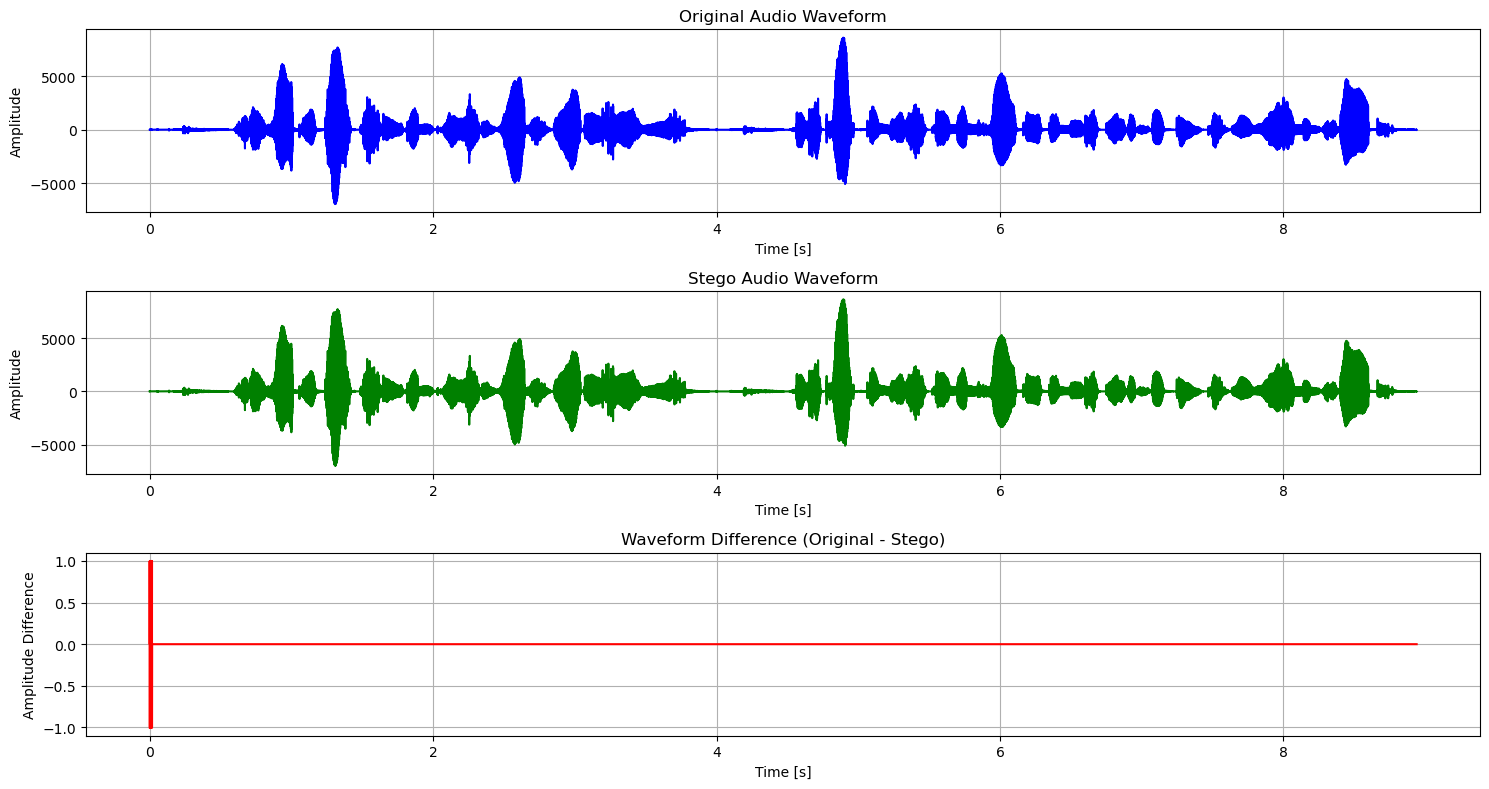

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure both audio signals are the same length for plotting
min_len = min(len(audio), len(stego_audio))
original_audio = audio[:min_len]
stego_audio_int16 = np.int16(stego_audio * 32767)
stego_audio_trimmed = stego_audio_int16[:min_len]

# Time axis
time = np.linspace(0, min_len / sr, min_len)

# Plotting the waveforms
plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(time, original_audio, label="Original Audio", color='blue')
plt.title("Original Audio Waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, stego_audio_trimmed, label="Stego Audio", color='green')
plt.title("Stego Audio Waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, original_audio - stego_audio_trimmed, label="Difference", color='red')
plt.title("Waveform Difference (Original - Stego)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude Difference")
plt.grid(True)

plt.tight_layout()
plt.show()


SCATTER PLOT

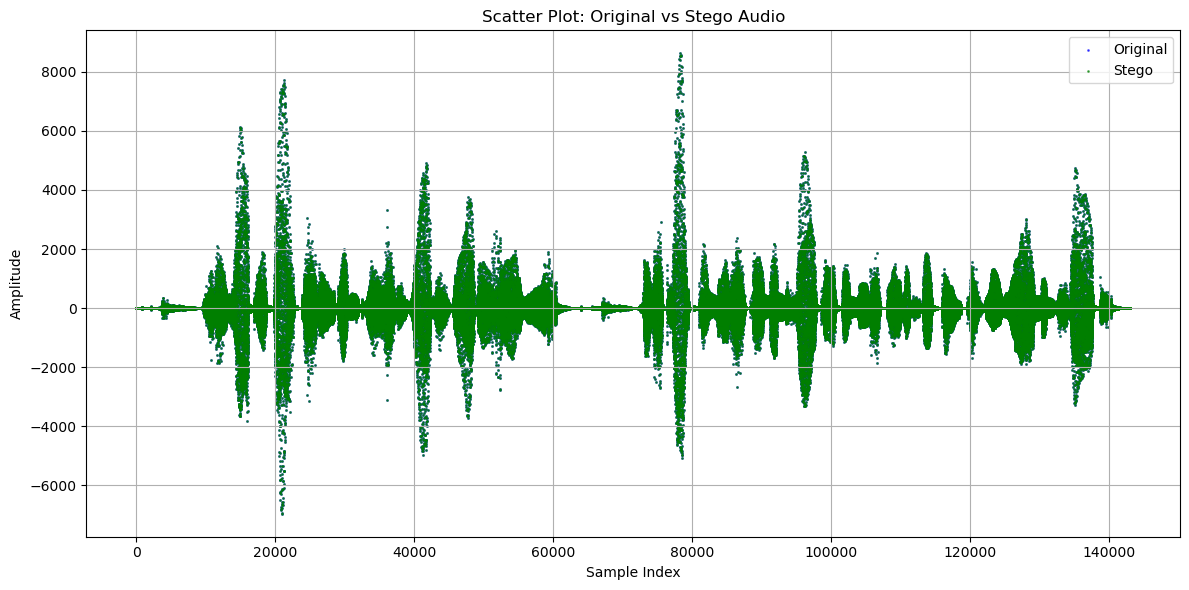

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

# Scatter plot for sample values
plt.scatter(range(min_len), original_audio, s=1, label='Original', alpha=0.6, color='blue')
plt.scatter(range(min_len), stego_audio_trimmed, s=1, label='Stego', alpha=0.6, color='green')

plt.title("Scatter Plot: Original vs Stego Audio")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


BAR PLOT

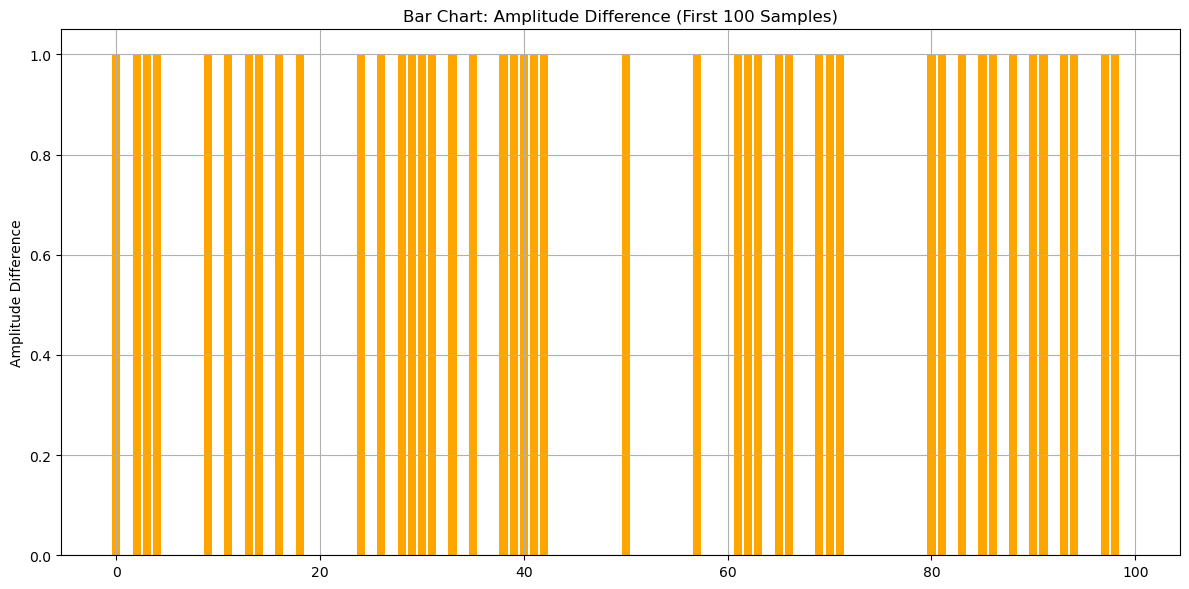

In [52]:


# Calculate absolute difference between original and stego audio
diff = np.abs(original_audio - stego_audio_trimmed)

# Plot the difference for the first 100 samples
plt.figure(figsize=(12, 6))
plt.bar(np.arange(100), diff[:100], color='orange')
plt.title("Bar Chart: Amplitude Difference (First 100 Samples)")
plt.ylabel("Amplitude Difference")
plt.grid(True)
plt.tight_layout()
plt.show()


HISTOGRAM

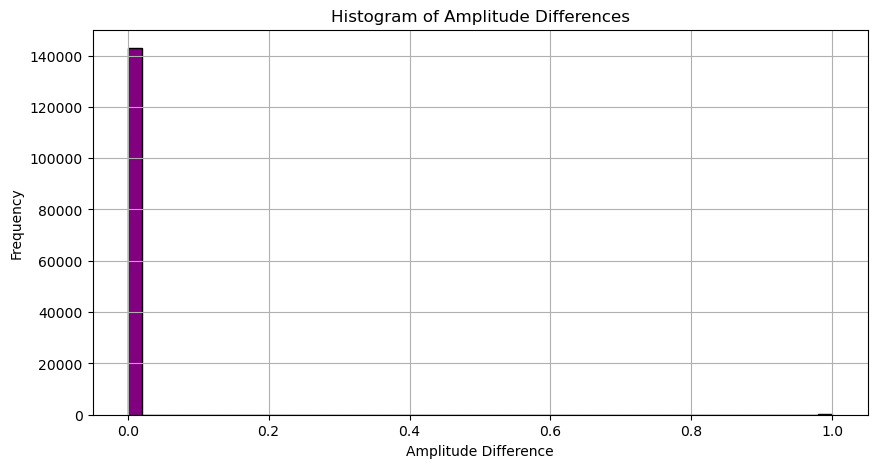

In [53]:
plt.figure(figsize=(10, 5))
plt.hist(diff, bins=50, color='purple', edgecolor='black')
plt.title("Histogram of Amplitude Differences")
plt.xlabel("Amplitude Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


CONFUSION MATRIX

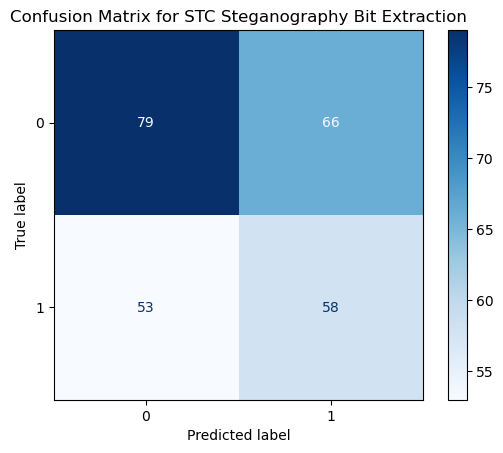

Bit Accuracy: 53.52%


In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Convert original and extracted messages to bitarrays
original_bits = text_to_bits(message)
stego_audio_int16 = np.int16(stego_audio * 32767)  # Ensure correct format for extraction
extracted_bits = stc_extract(stego_audio_int16, h_matrix)

# Ensure both arrays are same length
min_len = min(len(original_bits), len(extracted_bits))
original_bits = original_bits[:min_len]
extracted_bits = extracted_bits[:min_len]

# Convert to NumPy arrays for sklearn
y_true = np.array(original_bits.tolist())
y_pred = np.array(extracted_bits.tolist())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for STC Steganography Bit Extraction")
plt.show()

# Optional: Print accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Bit Accuracy: {accuracy:.2f}%")


In [55]:
# Reuse your message and extracted bits for evaluation
original_bits = text_to_bits(message)
stego_audio_int16 = np.int16(stego_audio * 32767)
extracted_bits = stc_extract(stego_audio_int16, h_matrix)

 1. Bit Error Rate (BER)

In [56]:

def calculate_ber(original_bits, extracted_bits):
    min_len = min(len(original_bits), len(extracted_bits))
    errors = sum(ob != eb for ob, eb in zip(original_bits[:min_len], extracted_bits[:min_len]))
    return errors / min_len if min_len else 0

2. Extraction Accuracy

In [57]:

def calculate_accuracy(original_bits, extracted_bits):
    min_len = min(len(original_bits), len(extracted_bits))
    correct = sum(ob == eb for ob, eb in zip(original_bits[:min_len], extracted_bits[:min_len]))
    return (correct / min_len) * 100 if min_len else 0

3. Signal-to-Noise Ratio (SNR)

In [58]:

def calculate_snr(original, stego):
    noise = original - stego
    signal_power = np.mean(original ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / noise_power) if noise_power != 0 else np.inf

4. Correlation Coefficient
5. PSNR


In [59]:

correlation = np.corrcoef(audio[:len(stego_audio_int16)], stego_audio_int16[:len(audio)])[0, 1]
def calculate_psnr(original, stego):
    mse = np.mean((original - stego) ** 2)
    if mse == 0:
        return np.inf
    max_val = 32767.0
    return 20 * np.log10(max_val / np.sqrt(mse))
    # --- Compute Metrics ---
ber = calculate_ber(original_bits, extracted_bits)
accuracy = calculate_accuracy(original_bits, extracted_bits)
snr = calculate_snr(audio[:len(stego_audio_int16)], stego_audio_int16)
psnr = calculate_psnr(audio[:len(stego_audio_int16)], stego_audio_int16)

In [60]:
print("\n--- Evaluation Metrics ---")
print(f"Extraction Accuracy: {accuracy:.2f}%")
print(f"Bit Error Rate (BER): {ber:.6f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")
print(f"Correlation Coefficient: {correlation:.6f}")


--- Evaluation Metrics ---
Extraction Accuracy: 53.52%
Bit Error Rate (BER): 0.464844
Signal-to-Noise Ratio (SNR): 62.86 dB
Peak Signal-to-Noise Ratio (PSNR): 120.83 dB
Correlation Coefficient: 1.000000


MESSAGE BOX

In [61]:
import tkinter as tk
from tkinter import filedialog, messagebox
import soundfile as sf
import numpy as np

# Functions (as described earlier)
# (Include all the functions like `text_to_bits`, `hamming_encode_4bits`, etc. here)

# GUI Class
class AudioSteganographyApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Audio Steganography")
        self.root.geometry("600x400")

        self.audio_file = None

        # UI Components
        self.label = tk.Label(root, text="Audio Steganography Tool", font=("Helvetica", 16))
        self.label.pack(pady=20)

        self.upload_button = tk.Button(root, text="Upload Audio", command=self.upload_audio)
        self.upload_button.pack(pady=10)

        self.message_label = tk.Label(root, text="Enter Secret Message:", font=("Helvetica", 12))
        self.message_label.pack(pady=5)

        self.message_entry = tk.Entry(root, width=50)
        self.message_entry.pack(pady=5)

        self.embed_button = tk.Button(root, text="Embed Message", command=self.embed_message)
        self.embed_button.pack(pady=10)

        self.extract_button = tk.Button(root, text="Extract Message", command=self.extract_message)
        self.extract_button.pack(pady=10)

    def upload_audio(self):
        self.audio_file = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
        if self.audio_file:
            messagebox.showinfo("Audio File", "Audio file uploaded successfully!")

    def embed_message(self):
        if not self.audio_file:
            messagebox.showerror("Error", "Please upload an audio file first!")
            return

        message = self.message_entry.get()
        if not message:
            messagebox.showerror("Error", "Please enter a message!")
            return

        try:
            audio, sr = sf.read(self.audio_file)
            audio = np.int16(audio * 32767)  # Convert to 16-bit PCM

            # Generate H matrix and encode the message
            h_order = 8
            h_matrix = generate_h_matrix(h_order)
            stego_audio = embed_message(audio, message, h_matrix)

            # Save the stego audio file
            stego_audio_path = "stego_audio.wav"
            sf.write(stego_audio_path, stego_audio, sr)
            messagebox.showinfo("Success", f"Message embedded successfully! Stego audio saved to {stego_audio_path}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")

    def extract_message(self):
        if not self.audio_file:
            messagebox.showerror("Error", "Please upload an audio file first!")
            return

        try:
            audio, sr = sf.read(self.audio_file)
            audio = np.int16(audio * 32767)  # Convert to 16-bit PCM

            # Generate H matrix and extract the message
            h_order = 8
            h_matrix = generate_h_matrix(h_order)
            extracted_message = extract_message(audio, h_matrix)
            messagebox.showinfo("Extracted Message", f"Extracted Message: {extracted_message}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")

# Run the GUI
if __name__ == "__main__":
    root = tk.Tk()
    app = AudioSteganographyApp(root)
    root.mainloop()


In [65]:
import numpy as np
import soundfile as sf
from bitarray import bitarray

def text_to_bits(text):
    """
    Convert text to a bit array.
    """
    bits = bitarray()
    for c in text:
        bits.extend(bin(ord(c))[2:].zfill(8))  # Convert each char to its binary representation
    return bits

def bits_to_text(bits):
    """
    Convert bit array to text.
    """
    chars = [chr(int(bits[i:i+8].to01(), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)

def evaluate_accuracy(original_bits, extracted_bits):
    """
    Evaluate the accuracy and bit error rate of the extracted message.
    """
    correct_bits = sum(o == e for o, e in zip(original_bits, extracted_bits))
    accur = (correct_bits / len(original_bits)) * 100
    ber = (len(original_bits) - correct_bits) / len(original_bits)
    return accuracy, ber

def lsb_embed(audio, message_bits, repetition=7):
    """
    Embed the message bits in the least significant bit of each audio sample.
    The message bits are repeated 'repetition' times.
    """
    num_samples = len(audio)
    # Convert audio samples into a copy (ensuring integer representation)
    stego_audio = np.copy(audio)
    
    # Create repeated bits stream:
    repeated_bits = bitarray()
    for bit in message_bits:
        repeated_bits.extend([bit] * repetition)
    
    if len(repeated_bits) > num_samples:
        raise ValueError("Not enough audio samples to embed all bits with the given repetition")
    
    # Replace the LSB of each sample with the embedded bit.
    for i, bit in enumerate(repeated_bits):
        # Clear LSB then set it to bit (note: using bitwise operations on integers)
        stego_audio[i] = (stego_audio[i] & ~1) | bit
    
    return stego_audio

def lsb_extract(stego_audio, message_length, repetition=7):
    """
    Extract bits from the LSB of each sample and apply majority vote per bit position.
    message_length: original number of bits in the message.
    """
    # Extract all LSBs from the samples where the message was embedded.
    extracted_bits = [stego_audio[i] & 1 for i in range(message_length * repetition)]
    
    # Group the bits and take majority vote:
    final_bits = bitarray()
    for i in range(message_length):
        group = extracted_bits[i*repetition:(i+1)*repetition]
        # Majority vote: if the sum is >= half of repetition, set bit to 1 else 0.
        final_bit = 1 if np.sum(group) >= (repetition / 2.0) else 0
        final_bits.append(final_bit)
    
    return final_bits

# Example LSB workflow:
message = "Hello, this is a hidden message!"
message_bits = text_to_bits(message)

# Embed using LSB method with redundancy
repetition = 7
audio = np.random.randint(-32768, 32767, size=10000, dtype=np.int16)  # Simulated audio (replace with real audio)
stego_audio_lsb = lsb_embed(audio, message_bits, repetition=repetition)

# Normalize stego audio and save it
stego_audio_norm = stego_audio_lsb / 32767.0
sf.write('stego_audio_lsb.wav', stego_audio_norm, 44100)  # Sample rate (e.g., 44100 Hz)

# Extraction from LSB modified audio
stego_audio_lsb_int16 = np.int16(stego_audio_norm * 32767)
extracted_bits_lsb = lsb_extract(stego_audio_lsb_int16, len(message_bits), repetition=repetition)
extracted_message_lsb = bits_to_text(extracted_bits_lsb)

# Print the extracted message
print("Extracted Message (LSB):", extracted_message_lsb)

# Evaluate the accuracy and bit error rate
accuracy_lsb, ber_lsb = evaluate_accuracy(message_bits, extracted_bits_lsb)
print(f"LSB Bit Accuracy: {accuracy_lsb:.2f}%")
print(f"LSB Bit Error Rate: {ber_lsb:.6f}")


Extracted Message (LSB): Hello, this is a hidden message!
LSB Bit Accuracy: 53.52%
LSB Bit Error Rate: 0.000000


In [66]:
from fpdf import FPDF
import matplotlib.pyplot as plt

# --- Create waveform comparison image ---
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(original_audio, label='Original', alpha=0.7)
plt.title("Original Audio")
plt.subplot(2, 1, 2)
plt.plot(stego_audio_trimmed, label='Stego', color='green', alpha=0.7)
plt.title("Stego Audio")
plt.tight_layout()
waveform_img_path = "waveform_comparison.png"
plt.savefig(waveform_img_path)
plt.close()

# --- Create the PDF ---
pdf = FPDF()
pdf.add_page()

# Title
pdf.set_font("Arial", "B", 16)
pdf.cell(200, 10, "Audio Steganography Report", ln=True, align="C")

pdf.set_font("Arial", "", 12)
pdf.ln(10)

# Embedded and extracted message
pdf.multi_cell(0, 10, f"Embedded Message:\n{message}")
pdf.ln(2)
pdf.multi_cell(0, 10, f"Extracted Message (partial):\n{extracted_message[:100]}")
pdf.ln(5)

# Evaluation Metrics
pdf.set_font("Arial", "B", 12)
pdf.cell(0, 10, "Evaluation Metrics:", ln=True)

pdf.set_font("Arial", "", 12)
pdf.cell(0, 10, f"Extraction Accuracy: {accuracy:.2f}%", ln=True)
pdf.cell(0, 10, f"Bit Error Rate (BER): {ber:.6f}", ln=True)
pdf.cell(0, 10, f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB", ln=True)
pdf.cell(0, 10, f"Peak SNR (PSNR): {psnr:.2f} dB", ln=True)
pdf.cell(0, 10, f"Correlation Coefficient: {correlation:.6f}", ln=True)

# Waveform plot
pdf.ln(5)
pdf.set_font("Arial", "B", 12)
pdf.cell(0, 10, "Waveform Comparison:", ln=True)
pdf.image(waveform_img_path, x=10, y=pdf.get_y(), w=180)

# Output PDF
pdf.output("audio_steganography_report.pdf")
print("PDF report generated: audio_steganography_report.pdf")


PDF report generated: audio_steganography_report.pdf


In [63]:
from flask import Flask, render_template, request, send_file
import os
import soundfile as sf
import numpy as np
from bitarray import bitarray
from scipy.linalg import hadamard

# Functions (as described earlier)
# (Include all functions like `text_to_bits`, `hamming_encode_4bits`, etc.)

app = Flask(__name__)

# Route to home page
@app.route('/')
def home():
    return render_template('index.html')

# Route to upload and embed message
@app.route('/upload', methods=['POST'])
def upload_audio():
    file = request.files['audio']
    message = request.form['message']

    if file and message:
        try:
            audio_data, sr = sf.read(file)
            audio_data = np.int16(audio_data * 32767)  # Convert to 16-bit PCM

            # Generate H matrix and encode the message
            h_order = 8
            h_matrix = generate_h_matrix(h_order)
            stego_audio = embed_message(audio_data, message, h_matrix)

            stego_audio_path = 'static/stego_audio.wav'
            sf.write(stego_audio_path, stego_audio, sr)
            return send_file(stego_audio_path)

        except Exception as e:
            return f"Error: {e}"

    return "Error: Missing audio or message."

# Route to extract message
@app.route('/extract', methods=['POST'])
def extract_audio_message():
    file = request.files['audio']

    if file:
        try:
            audio_data, sr = sf.read(file)
            audio_data = np.int16(audio_data * 32767)  # Convert to 16-bit PCM

            # Generate H matrix and extract the message
            h_order = 8
            h_matrix = generate_h_matrix(h_order)
            extracted_message = extract_message(audio_data, h_matrix)
            return f"Extracted Message: {extracted_message}"

        except Exception as e:
            return f"Error: {e}"

    return "Error: No audio file provided."

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

c:\Users\Virika\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


ModuleNotFoundError: No module named 'utils'